# Functions

In [62]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import operator
import pandas as pd
from scipy.signal import argrelmax
from scipy.signal import argrelmin
import numpy as np
from scipy.special import erfinv
import warnings
from scipy.optimize import minimize
warnings.filterwarnings("ignore") #this just stops the warning for log of negative number


def Persistence0D(sample_data, min_or_max = 0, edges = False): 
    #Input: Sample_data is the data set and min_or_max is wether you want 
    #peaks (1) or valleys (0)
    #Output: Indices of features, and persistence points (birth/death)

    # replace min_or_max with an integer to facilitate later processing
    if min_or_max == 'localMax': 
        min_or_max = 1
    else:
        min_or_max = 0
        
    
    from itertools import groupby
    sample_data = [k for k,g in groupby(sample_data) if k!=0]
    NegEnd = -100*np.max(np.abs(sample_data))
    if edges == False:
        #force local minima at edges for clipping
        sample_data = np.insert(sample_data, 0, NegEnd, axis=0)
        sample_data = np.insert(sample_data, len(sample_data), NegEnd, axis=0)
        sample_data = np.insert(sample_data, len(sample_data), NegEnd/2, axis=0)
        # find local minima and local maxima with ends clipped
        maxloc = np.array(argrelmax(sample_data, mode = 'clip'))
        minloc = np.array(argrelmin(sample_data, mode = 'clip'))
        temp = np.array(argrelmax(sample_data, mode = 'clip'))
        
    else:  # find local minima and local maxima with ends
        maxloc = np.array(argrelmax(sample_data, mode = 'wrap'))
        minloc = np.array(argrelmin(sample_data, mode = 'wrap'))
        temp = np.array(argrelmax(sample_data, mode =  'wrap'))

    max_vals = sample_data[maxloc]
    min_vals = sample_data[minloc]
    # create a matrix that will be used in the following part of the code
    minmax_mat = np.concatenate((min_vals, max_vals, minloc, maxloc), axis=0)
    
    
    i = 1
    L = len(maxloc[0])
    # prellocate the persistence diagram
    persistenceDgm = np.zeros((L,2))
    # preallocate the vector that will hold the time a desired feature was born
    feature_ind_1 = np.zeros((L,1))
    feature_ind_2 = np.zeros((L,1))
    
    # find the pairwise diferences
    # get the min-max pairs
    
    while (minmax_mat).shape[1] > 0.5: #while there is still values left in the matrix
        #stack the first two columns of minmax matrix (min values and max values)
        if maxloc[0][0] < minloc[0][0]: #if first value is a peak
            y = np.vstack((minmax_mat[1],minmax_mat[0])).T 
        else:                           #if first value is a valley
            y = np.vstack((minmax_mat[0],minmax_mat[1])).T
            
        y = y.reshape(2*len(minmax_mat[0]),)
        
        pairwiseDiff = abs(np.diff(y))
        
        # find index of the smallest difference
        differences = pairwiseDiff.reshape(len(pairwiseDiff),)
        smallestDiff_ind = min(enumerate(differences), key=operator.itemgetter(1))[0]
        
        if maxloc[0][0] < minloc[0][0]: #if first value is a peak
            ind1 = (int((smallestDiff_ind+1)/2))
            ind2 = (int((smallestDiff_ind)/2))
        else:                           #if first value is a valley
            ind1 = (int((smallestDiff_ind)/2))
            ind2 = (int((smallestDiff_ind+1)/2))

        
        # find the index to the peak that is on one end of the 
        # smallest difference
        peak_val = minmax_mat[1][ind1]
        # find the index to the peak val
        peak_ind = minmax_mat[3][ind1] 

        
        # remove the peak for next iteration
        minmax_mat[1][ind1] = np.NaN
        minmax_mat[3][ind1] = np.NaN
        
        # find the closest local minima to peak_ind
        valley_val = minmax_mat[0][ind2]
        # find the index to the valley val
        valley_ind = minmax_mat[2][ind2]
        # remove the valley for next iteration
        minmax_mat[0][ind2] = np.NaN
        minmax_mat[2][ind2] = np.NaN

        

        # record the 'time' the desired feature was born
        if valley_val > NegEnd:
            feature_ind_1[i-1] = (1-min_or_max)*valley_ind + min_or_max *peak_ind
            feature_ind_2[i-1] = (min_or_max)*valley_ind + (1-min_or_max)*peak_ind
            persDgmPnt = [valley_val, peak_val]
            persistenceDgm[i-1] = persDgmPnt
        
        # remove the NaN (delete the peaks and valleys that were just used)
        for j in range(0,4):
            temp = np.append([0],minmax_mat[j][~pd.isnull(minmax_mat[j])])
            minmax_mat[j] = temp
        minmax_mat=np.delete(minmax_mat,0,axis = 1)
        i=i+1
        
    if edges == False:
        #remove artifact last persistence feature and indices
        feature_ind_1 = feature_ind_1[:-1]
        feature_ind_2 = feature_ind_2[:-1]
        persistenceDgm = persistenceDgm[:-1]
    
    return feature_ind_1, feature_ind_2, persistenceDgm


def fit_two_curves(x, y, func1, func2, initial_guess):
    def func(v):
        f1 = (y-np.array(func1(x, v[0], v[1], v[2], v[3])))**2
        f2 = (y-np.array(func2(x, v[0], v[1], v[2], v[3])))**2
        f = np.stack((f1, f2))
        f = np.min(f, axis = 0)
        return np.sum(f) + np.max(f)
    
    v0 = initial_guess
    res = minimize(func, v0, method = 'BFGS', 
                   bounds = [(0,10*initial_guess[0]), 
                             (0,10*initial_guess[1]),
                             (0,10*initial_guess[2]),
                             (0,10*initial_guess[3])]
                   , tol = 10e-25)
    return res.x
    
    
def damping_param_estimation(damping_type, L, B, D, T_B, T_D, floor, L_all, T_all, params, plotting = False):
    
    I_all = np.argsort(T_all)
    T_all = T_all[I_all]
    L_all = L_all[I_all]
    if params == False:
        mass, N, spring = 1, 1, 1
    else:
        mass, N, spring = params[0], params[1], params[2]
        
    #---------------------------------------coulomb-------------------------------------
    if damping_type == 'coulomb': #coulomb
        if len(L) > 1:
            # Use equations and optimal ratio of lifetimes
            I_opt = np.argmin(np.abs((L-floor)/((L[0]-floor)) - 0.3299))
            # curve fitting
            def func1(data, a, b, c, d): # not all parameters are used here
                return -a*data + b + d
            
            def func2(data, a, b, c, d): # not all parameters are used here
                return b + 0*data
            
            b_guess = 0.01*np.max(L_all)
            m_guess = np.max(L_all)/np.max(T_all[L_all > 0.3299*np.max(L_all)]) 
            d_guess = np.max(L_all)
            initial_guess = [m_guess, b_guess, 0.0, d_guess]
            parameters = fit_two_curves(T_all, L_all, func1, func2, initial_guess)
            a, b, c, d = parameters
            zeta_fit = 0.5*a
            zeta_opt = (L[0] - L[I_opt])/(2*(T_B[I_opt] - T_B[0]))
            if params == False:
                mu_fit = np.nan
                mu_opt = np.nan
            else:
                omega_n = np.sqrt(spring/mass)
                mu_opt = spring*(L[0]-L[I_opt])/(8*N*(I_opt-0))
                zeta_opt = 2*mu_opt*N*omega_n/(np.pi*spring) #redefining because better estimate
                mu_fit = zeta_fit*np.pi*spring/(2*N*np.sqrt(spring/mass))
            if plotting == True:
                TextSize = 15
                plt.figure(0) 
                plt.figure(figsize=(8,3))
                plt.xlabel('$t$',size = TextSize)
                plt.ylabel('$L$',size = TextSize)
                plt.xticks(size = TextSize)
                plt.yticks(size = TextSize)
                plt.plot(T_all, L_all, 'k.', label = 'L')
                t_plotting = np.linspace(min(T_all),max(T_all), 500)
                plt.plot(t_plotting, func1(t_plotting, a, b, c, d), 'b--', label = '$f_S(t) = -mt+c+b$')
                plt.plot(T_all, func2(T_all, a, b, c, d), 'r-.', label = '$f_N(t) = b$')
                plt.xlim(0,)
                plt.legend(loc = 'upper right', fontsize = TextSize)
                plt.show()
        if len(L) > 0: #single lifetime
            if params == False:
                zeta_one = (B[0]+D[0])/(T_B[0] - T_D[0])
                mu_one = np.nan
            else:
                omega_n = np.sqrt(spring/mass)
                zeta_one = -omega_n*(B[0]+D[0])/(np.pi)
                mu_one = zeta_one*np.pi*spring/(2*N*np.sqrt(spring/mass))
            if len(L) == 1:
                mu_opt, zeta_opt, mu_fit, zeta_fit = np.nan, np.nan, np.nan, np.nan
        
    #---------------------------------------viscous-------------------------------------
    if damping_type == 'viscous': #Vsicous
        if len(L)>1: #multiple lifetimes
            # Use equations and optimal ratio of lifetimes
            I_opt = np.argmin(np.abs((L-floor)/((L[0]-floor)) - 0.3299))
            delta = np.log((L[0]-floor)/(L[I_opt]-floor))
            zeta_opt = np.sqrt(1/(1 + ((2*np.pi*(0-I_opt))/delta)**2))
            if params == False:
                mu_opt = np.nan
            else:
                mu_opt = zeta_opt*2*np.sqrt(mass*spring)
            
            # curve fitting
            def func1(data, a, b, c, d): # not all parameters are used here
                return (a) * np.exp(-c*data) + b
            
            def func2(data, a, b, c, d): # not all parameters are used here
                return b + 0*data
            t_opt = np.max(T_all[L_all>0.3299*np.max(L_all)])
            a_guess = np.max(L_all)
            b_guess = 0.01*np.max(L_all)
            c_guess = 2*np.log(1.0/0.3299)/t_opt
            initial_guess = [a_guess, b_guess, c_guess, 0.0]
            parameters = fit_two_curves(T_all, L_all, func1, func2, initial_guess)
            a, b, c, d = parameters
            if params == False:
                zeta_fit = (T_B[I_opt] - T_B[0])*c/(I_opt*2*np.pi)
                mu_fit = np.nan
            else:
                zeta_fit = c/np.sqrt(spring/mass)
                mu_fit = 2*zeta_fit*np.sqrt(spring*mass)
            if plotting == True:
                TextSize = 15
                plt.figure(0) 
                plt.figure(figsize=(8,3))
                plt.xlabel('$t$',size = TextSize)
                plt.ylabel('$L$',size = TextSize)
                plt.xticks(size = TextSize)
                plt.yticks(size = TextSize)
                plt.plot(T_all, L_all, 'k.', label = 'L')
                t_plotting = np.linspace(min(T_all),max(T_all), 500)
                plt.plot(t_plotting, func1(t_plotting, a, b, c, d), 'b--', label = '$f_S(t) = a{e}^{-c t} + b$')
                plt.plot(T_all, func2(T_all, a, b, c, d), 'r-.', label = '$f_N(t) = b$')
                plt.legend(loc = 'upper right', fontsize = TextSize)
                plt.xlim(0,)
                plt.show()
        if len(L) > 0: #single lifetime
            zeta_one = np.sqrt(1/(1+(np.pi/np.log((D[0]-0.5*floor)/(-B[0]-0.5*floor)))**2))
            if params == False:
                mu_one = np.nan
            else:
                mu_one = zeta_one*2*np.sqrt(mass*spring)
            if len(L) == 1:
                mu_opt, zeta_opt, mu_fit, zeta_fit = np.nan, np.nan, np.nan, np.nan
        
    #---------------------------------------Quadratic-------------------------------------
    if damping_type == 'quadratic': 
        zeta_one, mu_one = 1, 1
        n = len(L)
        if n > 0:
            if n > 4:
                n = 4
            mu_q_opts = []
            zeta_q_opts = []
            x = np.linspace(0.0,10,2000)
            for it in range(n):  
                V_i = B[it]+floor/2
                P_i = D[it]-floor/2
                L_i = L[it]-floor
                output = (L_i - (1/(2*x))*np.log((2*x*V_i - 1)/(2*x*P_i - 1)))**2
                min_indice = np.nanargmin(output)
                zeta_q_opt = x[min_indice]
                zeta_q_opts.append(zeta_q_opt)
                
                if params == False:
                    mu_q_opt = np.nan
                    mu_q_opts.append(mu_q_opt)
                else:
                    output = (L_i - (mass/(2*x))*np.log((2*x*V_i - mass)/(2*x*P_i - mass)))**2
                    min_indice = np.nanargmin(output)
                    mu_q_opt = zeta_q_opt*mass
                    mu_q_opts.append(mu_q_opt)
            zeta_opt = np.nanmedian(zeta_q_opts)
            zeta_one = zeta_q_opts[0]
            mu_opt = np.nanmedian(mu_q_opts)
            mu_one = mu_q_opts[0]
        else:
            print('Error: insufficient time series for quadratic damping analysis')
            zeta_opt, zeta_one, mu_opt, mu_one = np.nan, np.nan, np.nan, np.nan
        zeta_fit = np.nan
        mu_fit = np.nan
    
    
    damping_results = {'zeta_opt': zeta_opt, 'zeta_fit': zeta_fit, 'zeta_one': zeta_one,
                       'mu_opt': mu_opt, 'mu_fit': mu_fit, 'mu_one': mu_one}
    return damping_results
        
        
def cutoff_from_lifetimes(L, len_ts, alpha, sigma):
    if len(L) == 0:
        cutoff = 0
    else:
        if sigma == False:
            mu_L = np.median(L)
            cutoff = 1.923*mu_L*erfinv(2*(1-np.sqrt(alpha))**(1/len_ts) - 1)
        else:
            cutoff = 2**(3/2)*sigma*erfinv(2*(1-np.sqrt(alpha))**(1/len_ts) - 1)
    
        if cutoff > 0.3211*max(L):
            cutoff = 0.3211*max(L)
            
    return cutoff

def floor_from_lifetimes(L, t, L_sig, t_sig, cutoff, sigma):
        
    if len(L) > 0:
        alpha = 0.5
        t_stop = np.max(t_sig)
        N_stop = len(t[t<t_stop])
        n_floor = int(0.25*N_stop/len(L_sig)) + 1
        if sigma == False:
            mu_L = np.median(L)
            floor = 1.923*mu_L*erfinv(2*(1-np.sqrt(alpha))**(1/n_floor) - 1)
        else:
            floor = 2**(3/2)*sigma*erfinv(2*(1-np.sqrt(alpha))**(1/n_floor) - 1)
        
    if len(L) == 0:
        floor = 0
    if cutoff == 0.3211*max(L):
        floor = 0
        
    return floor

def damping_constant(t, ts, damping = 'viscous', params = False, sigma = False, alpha = 0.001, noise_comp = True, plotting = False):
    #-------------Program in warnings---------------
    if damping == 'quadratic' and np.abs(np.mean(ts)) > np.max(ts)-np.min(ts):
        print('Warning: for quadratic damping parameter estimation, it is required that the time series zero-meaned.')
        print('         It was indicated that this time series is not. Please change time series accordingly.')
    
    #-----------------------------------------------
    feature_ind_1, feature_ind_2, persistenceDgm = Persistence0D(ts, 'localMin', edges = False)
    #f_ind_1 and 2 are for birth and death indices, respectively.
    B = np.flip(persistenceDgm.T[0], axis = 0)
    D = np.flip(persistenceDgm.T[1], axis = 0)
    L = D-B
    I_B = np.array(feature_ind_1.astype(int)).T[0]
    I_D = np.array(feature_ind_2.astype(int)).T[0]
    I_D[I_D == len(ts)] = I_D[I_D == len(ts)] - 1 #shifts last death indice (at end of time series) over.
    T_B = np.flip(t[I_B], axis = 0)
    T_D = np.flip(t[I_D], axis = 0)
    cutoff = cutoff_from_lifetimes(L, len(ts), alpha, sigma)
    
    I_insig, I_sig = np.argwhere(L <= cutoff).T[0], np.argwhere(L > cutoff).T[0]
    L_sig, B_sig, D_sig, t_sig_B, t_sig_D = L[I_sig], B[I_sig], D[I_sig], T_B[I_sig], T_D[I_sig]
    L_noise, t_noise = L[I_insig],  T_B[I_insig]
    I_sort = np.argsort(t_sig_B)
    L_sig, B_sig, D_sig, t_sig_B, t_sig_D = L_sig[I_sort], B_sig[I_sort], D_sig[I_sort], t_sig_B[I_sort], t_sig_D[I_sort]
    
    if noise_comp == True:
        floor = floor_from_lifetimes(L, t, L_sig, t_sig_B, cutoff, sigma)
    else:
        floor = 0
    damping_results = damping_param_estimation(damping_type = damping, L = L_sig, B = B_sig, 
                                               D = D_sig, T_B = t_sig_B, T_D = t_sig_D, floor = floor, L_all = L, 
                                               T_all = T_B, params = params, plotting = plotting)
    if plotting == True:
        gs = gridspec.GridSpec(2,1) 
        TextSize = 15
        plt.figure(0) 
        plt.figure(figsize=(8,6))
        
        ax = plt.subplot(gs[0, 0])
        plt.ylabel('$x(t)$',size = TextSize)
        plt.setp( ax.get_xticklabels(), visible=False)
        plt.yticks(size = TextSize)
        plt.plot(t,ts, 'k', alpha = 1,  linewidth = 1.25, label = r'$x(t)+\mathcal{N}(0,\sigma^2)$')
        plt.xlim(0,max(t))
        
        ax = plt.subplot(gs[1, 0])
        plt.xlabel('$t$',size = TextSize)
        plt.ylabel('$L$',size = TextSize)
        plt.xticks(size = TextSize)
        plt.yticks(size = TextSize)
        plt.plot(T_B,L,'k.')
        plt.plot(t_noise,L_noise,'r.', alpha = 0.8, label = '$L_N$')
        plt.plot(t_sig_B,L_sig,'bd', label = '$L_F$')
        plt.plot([0,max(T_B)],[floor,floor],'k', label = '$\mathcal{F} = \;$'+str(round(floor,3)))
        plt.plot([0,max(T_B)],[cutoff,cutoff],'k--', label = r'$C_\alpha = \;$'+str(round(cutoff,3)))
        plt.plot([0,max(T_B)],[0.32*max(L), 0.32*max(L)],'k:', label = r'$0.3211 L_0$')
        plt.legend(loc = 'upper right', fontsize = TextSize-1)
        plt.xlim(0,max(t))
        
        plt.subplots_adjust(hspace=0.03)
        plt.show()
        
    results = {'damping_params': damping_results, 'floor': floor, 'cutoff': cutoff, 
               'L_sig': L_sig, 'B_sig': B_sig, 'D_sig': D_sig, 't_B': t_sig_B, 't_D': t_sig_D,
               'L': L, 'B': B, 'D': D, 'T_B': T_B, 'T_D': T_D}
    return results


# Example for Viscously Damped Oscillator (Example 1 in manuscript)

### Simulating signal

For this example, the system analyzed is the free response of the viscously damped oscillator described by $m\ddot{x} + kx + \mu_v \dot{x} = 0$,
where $m = 1$ kg, $k = 20$ N/m, and $\mu_v = 0.5$ Ns/m. This system is solved as
\begin{equation}
x(t) = e^{-\zeta \omega_n t} \cos (\omega_d t),
\label{eq:EOMsolvedexample}
\end{equation}
with initial conditions $x_0 = 1$ m and $\dot{x}_0 = 0$ m/s, where $\omega_n = \sqrt{k/m} \approx 4.472$ rad/s, $\zeta = 0.05590$, and $\omega_d = 4.465$ rad/s.
The simulation is sampled at a rate of $f_s = 20$ Hz for 20 seconds with additive noise $\mathcal{N}$ from a Gaussian distribution with a standard deviation $\sigma \approx 0.01$. 

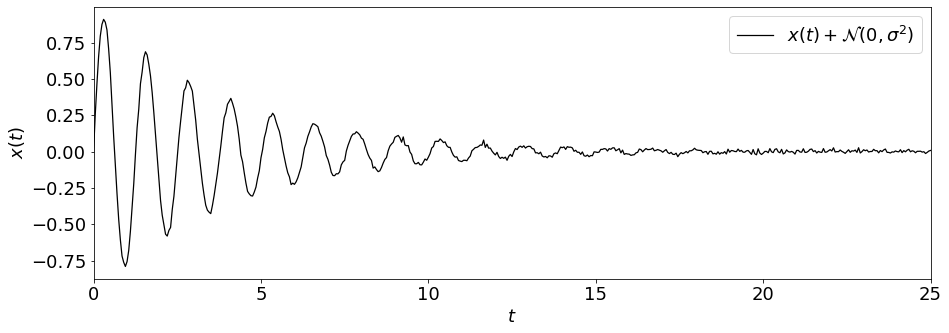

In [69]:
# import needed packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#simulation parameters
fs = 20 #sampling frequency (Hz)
t = np.arange(0,25.01,1/fs) #time

#damping mechanism
damping = 'viscous'

#system parameters
k, m, N = 25, 1, 9.81 # spring constant (k), mass (m), and normal force (N).
parameters = [m, N, k] # known system parameters to be used by functions.
mu_v = 0.5 # damping ratio which will be estimated from method.

# standard deviation of additive noise
SD = 0.01

#initial position condition (zero initial velocity)
x_0 = 1
dx_0 = 0


#other damped oscillator parameters 
omega_n = np.sqrt(k/m)
zeta = mu_v/(2*m*omega_n)
omega_d = omega_n*np.sqrt(1-zeta**2)

#generate signal
ts = x_0*np.exp(-zeta*omega_n*t)*np.sin(omega_d*t) + np.random.normal(0,SD, len(t))

#plot signal

plt.figure(figsize = (15,5))
TextSize = 18
plt.ylabel('$x(t)$',size = TextSize)
plt.xlabel('$t$', size = TextSize)
plt.yticks(size = TextSize)
plt.xticks(size = TextSize)
plt.plot(t,ts, 'k', alpha = 1,  linewidth = 1.25, label = r'$x(t)+\mathcal{N}(0,\sigma^2)$')
plt.xlim(0,max(t))
plt.legend(fontsize = TextSize)
plt.show()

### Estimating damping parameters


Using the lifetimes from the persistence diagram, a cutoff $C_\alpha = 0.119$ is calculated using $\alpha = 1\%$. To calculate the damping constant, the lifetime indices are chosen as $i=0$ and $n=3$ so that $L_{n+i}/L_{i} \approx 0.3211$ ($L_3/L_0 \approx 0.583/1.542 \approx 0.378$). Using these lifetimes, $\zeta_v$ is calculated as
\begin{equation*}
\zeta_v = \sqrt{\frac{1}{1+\left(\frac{2n\pi}{\ln \left({L_{i+n}}/{L_i}\right)} \right)^2}} = \sqrt{\frac{1}{1+\left(\frac{6\pi}{\ln \left({L_3}/{L_0}\right)} \right)^2}} \approx 0.05480.
\label{eq:visc_ref_used1}
\end{equation*}
Using $\zeta_v$ we then calculate $\mu_v = 2\zeta_v\sqrt{km} \approx 0.4901$. Both of these values are slightly below the theoretical values of $\zeta_v = 0.05590$ and $\mu_v = 0.5$. To improve the estimation, we can account for a noise floor in the calculation of $\zeta_v$ as
\begin{equation*}
\zeta_v = 2\sqrt{\frac{1}{1+\left(\frac{6\pi}{\ln \left({L_3-\mathcal{F}}/{L_0-\mathcal{F}}\right)} \right)^2}} \approx 0.05611,
\label{eq:visc_ref_used2}
\end{equation*}
where $\mathcal{F} \approx 0.018$ is calculated using the noise floor described in manuscript. We calculate $\mu_v = 2\zeta_v\sqrt{km} \approx 0.5019$ using the noise floor compensation, which is significantly closer to the actual $\mu_v = 0.5$. 

We also calculate the damping parameters using the function fitting procedure.

<Figure size 432x288 with 0 Axes>

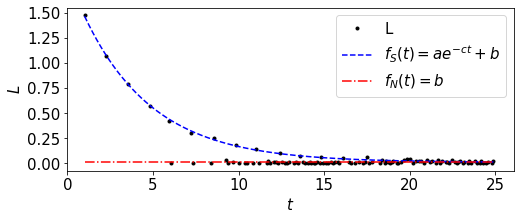

<Figure size 432x288 with 0 Axes>

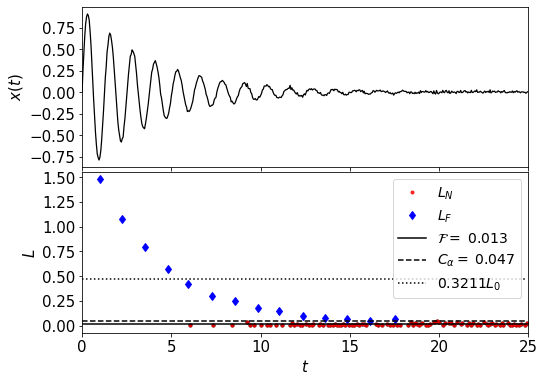

0.01309666859624373
dict_keys(['damping_params', 'floor', 'cutoff', 'L_sig', 'B_sig', 'D_sig', 't_B', 't_D', 'L', 'B', 'D', 'T_B', 'T_D'])
zeta (opt, fit, one):  0.0513 0.0494 0.0452
mu (opt, fit, one):    0.5125 0.494 0.4517


In [70]:
Result = damping_constant(t, ts, damping, params = parameters, alpha = 0.01, plotting = True)
SigFigs = 4
print(Result['floor'])
print(Result.keys())
print('zeta (opt, fit, one): ', 
      round(Result['damping_params']['zeta_opt'],SigFigs),
      round(Result['damping_params']['zeta_fit'],SigFigs),
      round(Result['damping_params']['zeta_one'],SigFigs))
print('mu (opt, fit, one):   ', 
      round(Result['damping_params']['mu_opt'],SigFigs),
      round(Result['damping_params']['mu_fit'],SigFigs),
      round(Result['damping_params']['mu_one'],SigFigs))